# 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
register_matplotlib_converters()
from time import time

%matplotlib inline

In [52]:
df = pd.read_csv('train.csv')

In [53]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

# 2. Data Preperation

In [54]:
df['OPERATIONDATE'] = pd.to_datetime(df['OPERATIONDATE'])

In [55]:
df['DATE'] = df['OPERATIONDATE'].dt.date

In [56]:
pt = df.pivot_table(index='DATE', columns='CASHPOINTID', values='AMT_SCALED', aggfunc='sum')
pt.index = pd.to_datetime(pt.index)

# 3. Exploration

In [57]:
pt[10]

DATE
2017-01-01    0.027462
2017-01-02    0.014423
2017-01-03    0.191506
2017-01-04    0.161240
2017-01-05    0.172166
                ...   
2019-12-27         NaN
2019-12-28         NaN
2019-12-29         NaN
2019-12-30         NaN
2019-12-31         NaN
Name: 10, Length: 1095, dtype: float64

Time: 197.28016328811646


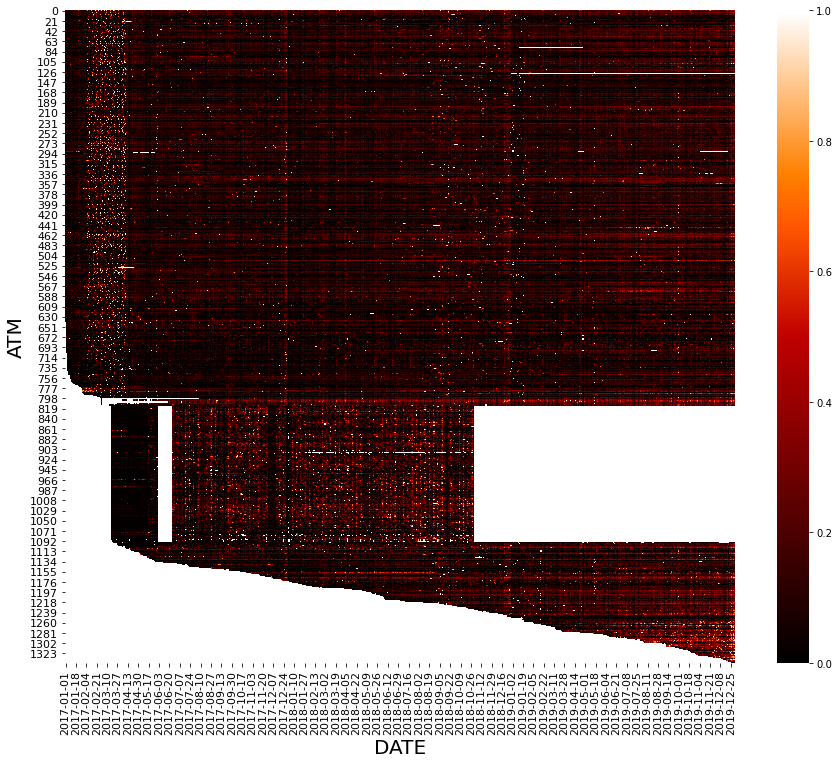

In [58]:
pt_img = pt
pt_img.index = pt_img.index.astype(str)
# pt_img.fillna(0, inplace=True)

start = time()

plt.figure(figsize=(15,12))

sns.heatmap(pt_img.transpose(),vmax=1, cmap='gist_heat')

plt.xlabel('DATE', fontsize=20)
plt.ylabel('ATM', fontsize=20)
plt.xticks(fontsize= 11, rotation=90)
plt.yticks(fontsize= 11, rotation=0)
plt.savefig('heat_map_nan.pdf')

end = time()
print('Time:', end - start)

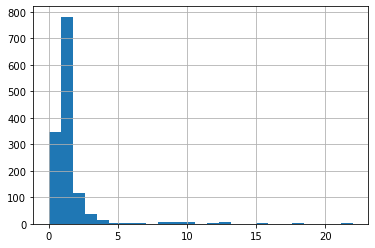

In [8]:
# Count zeros in series

pt[pt==0].count().hist(bins=25);

In [10]:
# Inactive ATMs
# Inactive ATMs in last 30 days - 419 (Active - 924)

last_month = pt.loc['2019-12-1':'2019-12-31']
inactive_atm = []
for i in range(len(last_month.columns)):
    if last_month[i].sum()==0:
        inactive_atm.append(i)
len(inactive_atm)

419

In [11]:
first_two_years = pt.loc['2017-1-1':'2019-1-31']
new_atm = []
for i in range(len(first_two_years.columns)):
    if first_two_years[i].sum()==0:
        new_atm.append(i)     
len(new_atm)

84

In [12]:
active_atm = pt.drop(pt.columns[inactive_atm], axis=1)

In [13]:
gb = pt.groupby(pt.index.strftime('%m-%d')).mean()
gb.index = gb.index.str.cat(pd.Series('2020'), sep = "-", na_rep = pd.Series('2020'))
gb.index = pd.to_datetime(gb.index)

In [14]:
jan_pred = gb[gb.index <= '2020-01-31']

In [15]:
# Fill ZEROs for group 2 ATMs

for col in jan_pred.loc[:,inactive_atm].columns:
    jan_pred.loc[:,col] = 0

C:\Users\giorgi.kokaia\Anaconda3\lib\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
C:\Users\giorgi.kokaia\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [16]:
# Select ATMs with NaN in forecasted perion and replace with mean of the given period

nan_atm = jan_pred.columns[jan_pred.isna().any()]

pt.index = pd.to_datetime(pt.index)

gb_3 = pt[nan_atm].groupby(pt.index.strftime('%d')).mean()
gb_3.index=jan_pred.index

jan_pred.loc[:,nan_atm] = gb_3

In [17]:
# Select ATMs with NaN in forecasted perion and replace with mean of the column

nan_atm = jan_pred.columns[jan_pred.isna().any()]
jan_pred[nan_atm] = jan_pred[nan_atm].fillna(jan_pred[nan_atm].mean())

C:\Users\giorgi.kokaia\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [21]:
result = pd.melt(jan_pred.reset_index(),id_vars='DATE')
result = result[['CASHPOINTID','DATE','value']]
result.columns = ['CASHPOINTID','OPERATIONDATE','AMT_SCALED']

In [40]:
# result.to_csv('result.csv')

In [43]:
c = 1250
for i in range(5): 
    plt.figure(figsize=(18,2))
    plt.plot(pt[c+i])
    plt.plot(jan_pred[c+i])

ValueError: view limit minimum -36872.75 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units